In [1]:
import phoebe
from phoebe import u # units
import numpy as np

logger = phoebe.logger()

### Generate data

Let's first initialize a bundle and change some of the parameter values. We'll then export the computed models as "observables" to use with the EBAI and lc_geometry estimators.

In [2]:
b = phoebe.default_binary()
# set parameter values
b.set_value('q', value = 0.6)
b.set_value('incl', component='binary', value = 84.5)
b.set_value('ecc', 0.2)
b.set_value('per0', 63.7)
b.set_value('requiv', component='primary', value=1.)
b.set_value('requiv', component='secondary', value=0.6)
b.set_value('teff', component='secondary', value=5500.)

# add an lc dataset
b.add_dataset('lc', compute_phases=phoebe.linspace(0,1,101))

#compute the model
b.run_compute(irrad_method='none')

# extract the arrays from the model that we'll use as observables in the next step
times = b.get_value('times', context='model', dataset='lc01')
# here we're adding noise to the fluxes as well to make the fake data more "realistic"
np.random.seed(0) # to ensure reproducibility with added noise
fluxes = b.get_value('fluxes', context='model', dataset='lc01') + np.random.normal(size=times.shape) * 0.02
sigmas_lc = np.ones_like(times) * 0.04

### Initialize the bundle

To showcase the estimators, we'll start with a fresh default bundle and set the *pblum_mode* to *dataset-scaled* to simplify the comparison between the light curves.

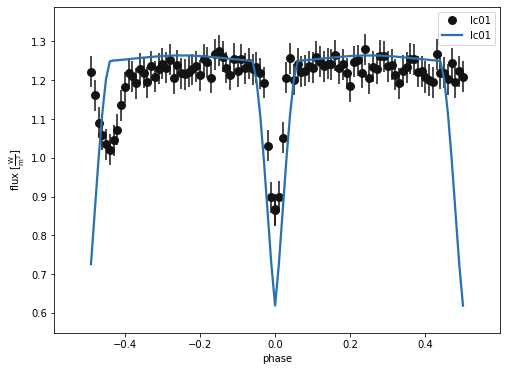

(<autofig.figure.Figure | 1 axes | 2 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [3]:
b = phoebe.default_binary()
b.add_dataset('lc', times=times, fluxes=fluxes, sigmas=sigmas_lc)
b.set_value('pblum_mode', 'dataset-scaled')

b.run_compute(model='default')
b.plot(x='phase', legend=True, show=True)

### EBAI

Let's start with the EBAI solver, which with the help of a trained neural network estimates of the time of superior conjunction, sum of equivalent radii, inclination,  temperature ratio, esinw and ecosw.

In [4]:
b.add_solver('estimator.ebai')
print(b['ebai01'])

Wed, 05 Aug 2020 15:34 BUNDLE       WARNING adding teffratio constraint to binary orbit (needed for ebai solver)
Wed, 05 Aug 2020 15:34 BUNDLE       WARNING adding requivsumfrac constraint to binary orbit (needed for ebai solver)


ParameterSet: 5 parameters
           comments@ebai01@solver: 
        lc_datasets@ebai01@solver: ['*']
          phase_bin@ebai01@solver: True
        phase_nbins@ebai01@solver: 500
              orbit@ebai01@solver: binary


As we can see, by default it selects all available LC datasets and bins the light curves to 500 bins. We can change any of these in the 'ebai01' object or in the call to *run_solver*. If there are less points that bins, the phase binning is skipped. Just in case, let's turn off the phase binning for this example, since we already have only 100 data points.

In [5]:
b['phase_bin@ebai01'] = False
print(b['ebai01'])

ParameterSet: 4 parameters
           comments@ebai01@solver: 
        lc_datasets@ebai01@solver: ['*']
          phase_bin@ebai01@solver: False
              orbit@ebai01@solver: binary


In [6]:
b.run_solver('ebai01', solution='ebai_solution')

/home/angela/anaconda3/lib/python3.7/site-packages/phoebe/solverbackends/lc_geometry.py:73: RuntimeWarning: invalid value encountered in greater
  ph_cross = phases[fluxes - np.nanmedian(fluxes) > 0]


<ParameterSet: 14 parameters | qualifiers: input_sigmas, orbit, adopt_parameters, ebai_fluxes, adopt_values, fitted_units, fitted_uniqueids, adopt_distributions, comments, fitted_twigs, input_phases, ebai_phases, input_fluxes, fitted_values>

Some of the parameters that the EBAI estimator returns are constrained, so to properly set their values through *adopt_solution*, we need to flip the relevant constriants first. Note that simply running *adopt_solution()* without this step will result in an error.

In [7]:
b.flip_constraint('requivsumfrac', solve_for='requiv@secondary')

b.flip_constraint('teffratio', solve_for='teff@secondary')
b.flip_constraint('esinw', solve_for='ecc')
b.flip_constraint('ecosw', solve_for='per0')

Wed, 05 Aug 2020 15:34 BUNDLE       ERROR   Constraint 'ecc@binary@orbit@constraint' raised the following error while attempting to solve for 'ecc@binary@orbit@component'.  Consider flipping the constraint or changing the value of one of ['per0@binary@orbit@component', 'esinw@binary@orbit@component', 'ecosw@binary@orbit@component', 'ecc@binary@orbit@component'] until the constraint succeeds.  Original error: esinw=0.0 and per0=0.0 results in nan for ecc


<ConstraintParameter: {per0@binary@component} = arctan2({esinw@binary@component}, {ecosw@binary@component}) (solar units) => 0.0 deg>

In some cases, the estimator won't be able to determine all parameters and return nans instead. To make sure we don't try to update those parameters in the Bundle, we can check and only include the parameters without nan values in the *adopt_parameters* list:

In [8]:
adopt_params = []
for i, val in enumerate(b['value@fitted_values@ebai_solution']):
    if np.isnan(val):
        pass
    else:
        adopt_params.append(b['value@adopt_parameters@ebai_solution'][i])
b['adopt_parameters@ebai_solution'] = adopt_params

Finally, we can adopt the EBAI solution and see how it has improved the model light curve:

Wed, 05 Aug 2020 15:34 BUNDLE       WARNING solution='ebai_solution' is not included in run_checks_solution@setting, so will not raise interactive warnings


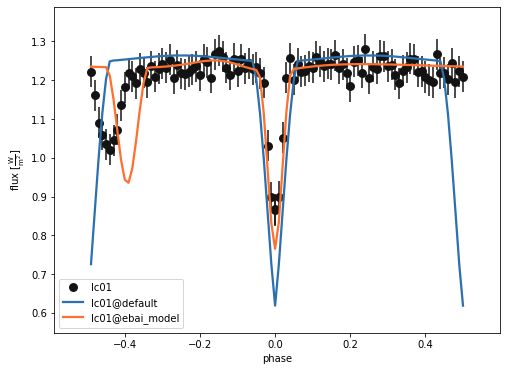

(<autofig.figure.Figure | 1 axes | 3 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [9]:
b.adopt_solution('ebai_solution')
b.run_compute(model='ebai_model')
b.plot(x='phase', ls='-', legend=True, show=True)

### lc_geometry

The EBAI estimator is known to have deficiencies in correctly estimating the eccentricity and argument of periastron, which can be seen in our solution too. To improve this, we can use the lc_geometry estimator, which is specifically tailored to estimating eccentricty and argument of periastron by determining the eclipse separation and widths.

In [10]:
b.add_solver('estimator.lc_geometry', solver='lcgeom')

<ParameterSet: 8 parameters | qualifiers: expose_model, orbit, phase_bin, phase_nbins, lc_datasets, t0_near_times, lc_combine, comments>

In [11]:
print(b['lcgeom'])

ParameterSet: 7 parameters
           comments@lcgeom@solver: 
        lc_datasets@lcgeom@solver: ['*']
          phase_bin@lcgeom@solver: True
        phase_nbins@lcgeom@solver: 500
              orbit@lcgeom@solver: binary
      t0_near_times@lcgeom@solver: True
       expose_model@lcgeom@solver: True


The lc_geometry estimator takes similar inputs as EBAI, with two additions: *t0_near_times*, which will return the value of t0_supconj such that it falls within or near the provided times array (otherwise it will be a value in the range [0, period]) and *expose_model*, which if true returns the analytical, two-Gaussian model fit that's used to determine the eclipse parameters.

By default, the estimator will only return the resulting parameter values, however, in lc_geometry we can pass *diagnose=True* if we want to see or even adjust the underlying fit. Try running the solver with an interactive plotting option and drag the eclipse position lines in the plot!

In [12]:
%matplotlib qt
b.run_solver('lcgeom', solution='lcgeom_solution', diagnose=True)

/home/angela/anaconda3/lib/python3.7/site-packages/phoebe/solverbackends/lc_geometry.py:73: RuntimeWarning: invalid value encountered in greater
  ph_cross = phases[fluxes - np.nanmedian(fluxes) > 0]


adjusting values


<ParameterSet: 22 parameters | qualifiers: adopt_distributions, fitted_twigs, comments, input_sigmas, adopt_values, fitted_uniqueids, primary_depth, analytic_best_model, orbit, eclipse_edges, secondary_depth, fitted_units, input_phases, analytic_phases, primary_width, primary_phase, analytic_fluxes, adopt_parameters, secondary_phase, secondary_width, input_fluxes, fitted_values>

The resulting solution returns our values of interest: eccentricity and argument of periastron, as well as the analytical fluxes of all two-Gaussian models (since *expose_models = True*) and the eclipse parameters determined from the best fit:

In [13]:
print(b['lcgeom_solution'])

ParameterSet: 22 parameters
R  orbit@lcgeom@lcgeom_solutio...: binary
R  input_phases@lcgeom@lcgeom_...: [-0.49 -0.48 -0.47 ...  0.48
  0.49  0.5 ]
R  input_fluxes@lcgeom@lcgeom_...: [0.99914028 0.94873774
 0.8911056  ... 0.97682163
 0.99962626 0.98820163]
R  input_sigmas@lcgeom@lcgeom_...: [0.03269359 0.03269359
 0.03269359 ... 0.03269359
 0.03269359 0.03269359]
R  analytic_phases@lcgeom_solu...: [-0.5   -0.495 -0.49  ...  0.49
  0.495  0.5  ]
R  analytic_fluxes@lcgeom_solu...: {'C': array([0.98333389, 0.98333389, 0.98333389, 0.98333389, 0.98333389,
       0.98333389, 0.98333389, 0.98333389, 0.98333389, 0.98333389,
       0.98333389, 0.98333389, 0.98333389, 0.98333389, 0.98333389,
       0.98333389, 0.98333389, 0.98333389, 0.98333389, 0.98333389,
       0.98333389, 0.98333389, 0.98333389, 0.98333389, 0.98333389,
       0.98333389, 0.98333389, 0.98333389, 0.98333389, 0.98333389,
       0.98333389, 0.98333389, 0.98333389, 0.98333389, 0.98333389,
       0.98333389, 0.98333389, 0.98333389

To update the values in the bundle, we need to reverse-flip the constraints for esinw and ecosw and adopt the solution.

In [14]:
b.flip_constraint('per0', solve_for='ecosw')
b.flip_constraint('ecc', solve_for='esinw')

<ConstraintParameter: {esinw@binary@component} = {ecc@binary@component} * (sin({per0@binary@component})) (solar units) => 0.1094071387702985>

Wed, 05 Aug 2020 15:35 BUNDLE       WARNING solution='lcgeom_solution' is not included in run_checks_solution@setting, so will not raise interactive warnings
Wed, 05 Aug 2020 15:35 PARAMETERS   WARNING wrapping value of mean_anom to 10.899181191350579 deg


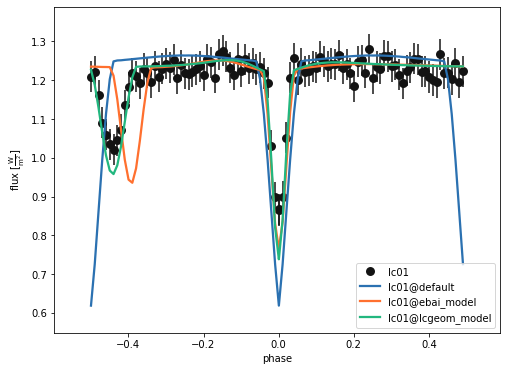

(<autofig.figure.Figure | 1 axes | 4 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [15]:
b.adopt_solution('lcgeom_solution')
b.run_compute(model = 'lcgeom_model')
%matplotlib inline
b.plot(x='phase', ls='-', legend=True, show=True)

### * phase masking

lc_geometry also returns suggested *mask_phases* computed from the eclipse widths, which we can notice in the list of *fitted_twigs*. However, by default it is excluded from the *adopt_parameters* list:

In [16]:
print(b['value@fitted_twigs@lcgeom_solution'])
print(b['value@adopt_parameters@lcgeom_solution'])

['t0_supconj@binary@orbit@component' 'ecc@binary@orbit@component'
 'per0@binary@orbit@component' 'mask_phases@binary@lc01@lc@dataset']
['t0_supconj@binary@orbit@component', 'ecc@binary@orbit@component', 'per0@binary@orbit@component']


Therefore, we can set them in the bundle by either adding *mask_phases* the to the *adopt_parameters* list before calling *adopt_solution()*, or after, as:

In [17]:
b['mask_phases'] = b['value@fitted_values@lcgeom_solution'][-1]

If we now plot the light curves, we'll see only the eclipses have been "masked out" of the data.

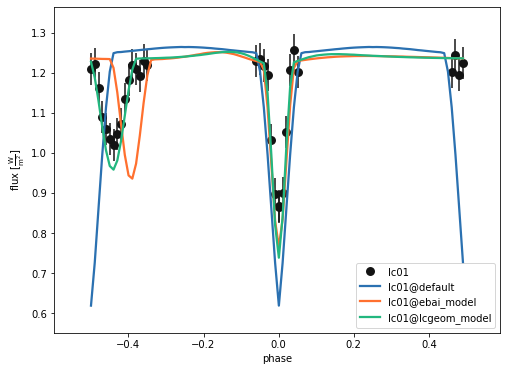

(<autofig.figure.Figure | 1 axes | 4 call(s)>,
 <Figure size 576x432 with 1 Axes>)

Wed, 05 Aug 2020 15:35 tornado.application ERROR   Exception in callback functools.partial(<function Kernel.enter_eventloop.<locals>.advance_eventloop at 0x7ff7cc86ed40>)
Traceback (most recent call last):
  File "/home/angela/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/angela/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 310, in advance_eventloop
    eventloop(self)
TypeError: 'NoneType' object is not callable


In [18]:
b.plot(x='phase', ls='-', legend=True, show=True)